# IMLT Breast Cancer Classification Project
### Levent Dusunceli

As a part of the finishing project for Introduction to Machine Learning Techniques (IMLT) class, we were tasked with finding a good classification algorithm for a curated version of Wisconsin Breast Cancer Dataset.  

More information about the dataset can be found here: http://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(diagnostic) 



Our project has 3 main parts: 
1. Data Preprocessing 
2. Algorithm Optimization 
3. Feature Importance Evaluation 


At the end of the project, we include a brief literature review comparing our best performing algorithm with the currently available literature on prognostic factors of breast cancer

# Data Preprocessing 

In data preprocessing, we'll check if there's any NaN values, imbalances or any correlations in the dataset. We'll mitigate the correlation and imbalances if there's any.

After these operations, we'll split the dataset into training and test sets.  Then we'll move to assesing the performance of different algorithms

In [304]:
import pandas as pd 
import matplotlib.pyplot as plt


data = pd.read_csv('Breast_Cancer.csv')
data = data.iloc[:,1:] #removing the sample code number

In [305]:
data.isnull().any()

Clump Thickness                False
Uniformity of Cell Size        False
Uniformity of Cell Shape       False
Marginal Adhesion              False
Single Epithelial Cell Size    False
Bare Nuclei                    False
Bland Chromatin                False
Normal Nucleoli                False
Mitoses                        False
Class                          False
dtype: bool

### Variation 

We're checking variance to see if we'll need standard scaling

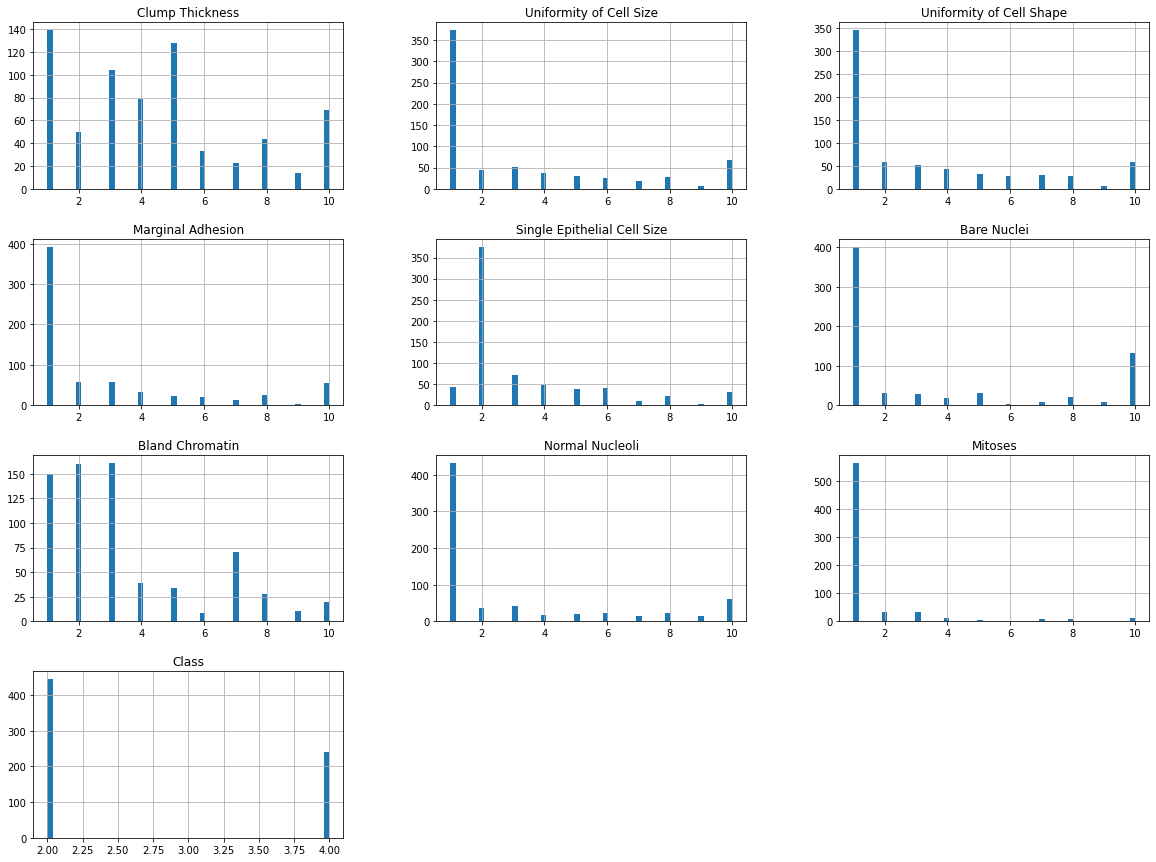

In [306]:
data.hist(bins=50, figsize = (20,15))
plt.show()

All values are between the values of 0 and 10, therefore are in the same scale.  This means standard scaling is not required

### Balance of data 

We'll check if two classes of breast cancer data are balanced.  If not, in order to conserve the amount of our data, we'll use data upsampling to cure this imbalace.

In [307]:
data.Class.value_counts()

2    444
4    239
Name: Class, dtype: int64

The malignant class is underrepresented by a ratio close to 2-1

In [308]:
#For upsampling we'll use resample package from sklearn 

from sklearn.utils import resample 

df_benign = data[data.Class==2]
df_malignant = data[data.Class==4]

df_mlg_upsampled = resample(df_malignant,replace=True,n_samples=444,random_state=23)

data_upsampled = pd.concat([df_benign,df_mlg_upsampled],ignore_index=True)
data_upsampled.Class.value_counts()

2    444
4    444
Name: Class, dtype: int64

### Correlation  

Now we'll check the correlation coefficient to see if any two variables are correlated

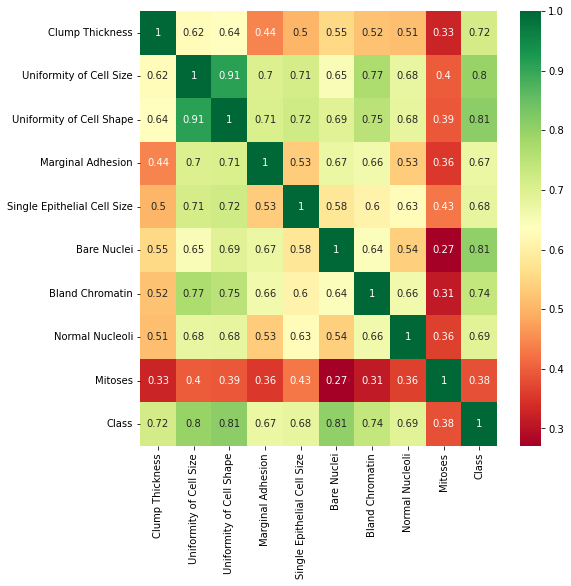

In [309]:
import seaborn as sns

corrmat = data_upsampled.corr()
top_corr_features = corrmat.index 
plt.figure(figsize=(8,8)) 
g=sns.heatmap(data_upsampled[top_corr_features].corr(),annot=True,cmap="RdYlGn")

It can be seen that only highly correlated features are **Uniformity of Cell Size and Uniformity of Cell Shape**. In order to fix this correlation we're going to take the mean of two columns to create a new variable.

In [310]:
data_upsampled.dtypes

Clump Thickness                int64
Uniformity of Cell Size        int64
Uniformity of Cell Shape       int64
Marginal Adhesion              int64
Single Epithelial Cell Size    int64
Bare Nuclei                    int64
Bland Chromatin                int64
Normal Nucleoli                int64
Mitoses                        int64
Class                          int64
dtype: object

In [311]:
#insert empty column 
data_upsampled.insert(1,'Uniformity Cell Size/Shape','')


#take mean of two columns and add it to the new column 
for i in range(len(data_upsampled)):
    data_upsampled.at[i,'Uniformity Cell Size/Shape'] = (( data_upsampled.iloc[i]['Uniformity of Cell Size'] + data_upsampled.iloc[i]['Uniformity of Cell Shape'])/2).astype(int)

#drop highly correlated columns     
data_upsampled.drop(['Uniformity of Cell Size','Uniformity of Cell Shape'],axis=1,inplace = True)

Our correlation matrix will only calculate feature correlations among integer columns.  Our newly added column is in object data type.  We'll convert this to integer

In [312]:
data_upsampled['Uniformity Cell Size/Shape']=data_upsampled['Uniformity Cell Size/Shape'].astype(str).astype(int)

In [313]:
data_upsampled.dtypes

Clump Thickness                int64
Uniformity Cell Size/Shape     int64
Marginal Adhesion              int64
Single Epithelial Cell Size    int64
Bare Nuclei                    int64
Bland Chromatin                int64
Normal Nucleoli                int64
Mitoses                        int64
Class                          int64
dtype: object

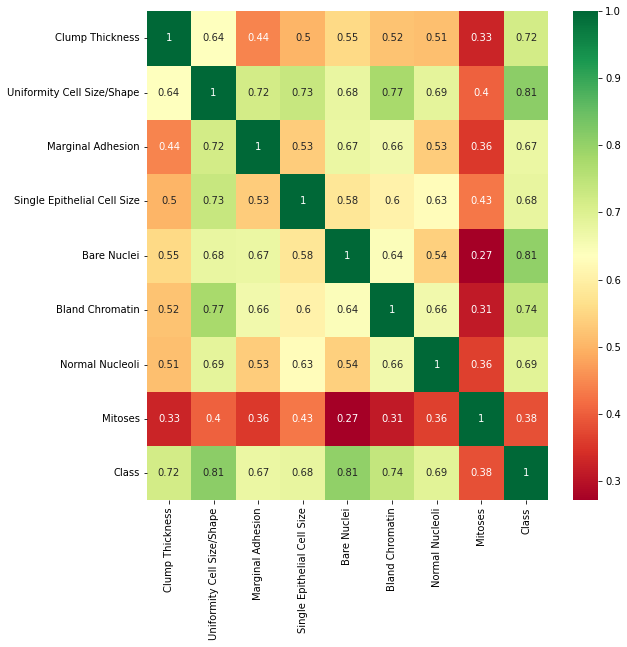

In [314]:
corrmat = data_upsampled.corr()
top_corr_features = corrmat.index 
plt.figure(figsize=(9,9)) 
g=sns.heatmap(data_upsampled[top_corr_features].corr(),annot=True,cmap="RdYlGn")

### Train-test split 

For the split we chose a 3/1 ratio. 

In [315]:
x = data_upsampled.iloc[:,:-1].values
y = data_upsampled.iloc[:,-1].values

#changing condition labels to 0/1 so that F1 score can be calculated 
y[y==2]=0
y[y==4]=1

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size= 0.25,random_state=23)

-------------------------------

# Algorithm Optimization & Evaluation

When performing the evaluation of algorithms, in order to select the best estimators, we'll first evaluate each algorithm within itself with different parameters using GridSearch.  Then we'll compare the F1 score and AUROC metrics of the best estimator of each algorithm. We will also plot feature importances for the algorithms that have such an attribute 

Algorithms to be evaluated: 
- kNN
- Logistic regression 
- SVM 
- Decision tree
- Random forest 
- AdaBoost 
- GradientBoost

In [316]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score 
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

### kNN 

kNN doesn't return feature importances therefore we will only perform a grid search. 

In [317]:
from sklearn.neighbors import KNeighborsClassifier

params_grid = { 'n_neighbors':[3,5,7,10,20],'weights':['uniform','distance'],
              'metric':['euclidean','manhattan']}


#we're going to add a cross validation method to our GridSearch because 
#if we define only an integer for the cv=() parameter, the results will depend 
#on cross validation splits and will give different parameters everytime we run the code

cross_val = StratifiedKFold(shuffle=True,random_state=23) 

gs_knn = GridSearchCV(KNeighborsClassifier(),params_grid,cv=cross_val,n_jobs=-1)

knn_results = gs_knn.fit(x_train,y_train)

knn_results.best_estimator_,knn_results.best_params_

(KNeighborsClassifier(metric='euclidean', n_neighbors=3, weights='distance'),
 {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'})

According to our GridSearch, using Euclidean distances with 3 neighbors and distance weighted classification is our best estimator.  Now we'll perform classification with these parameters and evaluate the performance using F1 score and AUROC 

In [340]:
knn = KNeighborsClassifier(n_neighbors=3,weights='distance',metric='euclidean')

knn.fit(x_train,y_train)
knn_pred = knn.predict(x_test)

knn_f1 = f1_score(y_test,knn_pred)
knn_auroc = roc_auc_score(y_test,knn_pred)

print('F1 score for kNN: {:.4f}'.format(knn_f1),'\n',
     'AUROC score for kNN: {:.4f}'.format(knn_auroc))


F1 score for kNN: 0.9573 
 AUROC score for kNN: 0.9618


### Logistic Regression 

For logistic regression we're going to perform a gridsearch and also plot the feature importances

In [339]:
from sklearn.linear_model import LogisticRegression

params_grid = { 'penalty':['l2',None],'C':[0.01,0.1,1,10],
              'solver':['newton-cg','sag','lbfgs'],'random_state':[23]}

cross_val = StratifiedKFold(shuffle=True,random_state=23)

gs_lr = GridSearchCV(LogisticRegression(),params_grid,cv=cross_val,n_jobs=-1)

lr_results = gs_lr.fit(x_train,y_train)

lr_results.best_estimator_,lr_results.best_params_

(LogisticRegression(C=0.1, random_state=23, solver='newton-cg'),
 {'C': 0.1, 'penalty': 'l2', 'random_state': 23, 'solver': 'newton-cg'})

According to our GridSearch, using C value of 0.1 with l2 penalization and newton-cg solver is our best estimator

In [342]:
LogReg = LogisticRegression(penalty='l2',solver='newton-cg',C=0.1,n_jobs=-1,random_state=23)

LogReg.fit(x_train,y_train)

lr_pred = LogReg.predict(x_test)

lr_f1 = f1_score(y_test,lr_pred)
lr_auroc = roc_auc_score(y_test,lr_pred)

print('F1 score for Logistic Regression: {:.4f}'.format(lr_f1),'\n',
     'AUROC score for Logistic Regression: {:.4f}'.format(lr_auroc))

F1 score for Logistic Regression: 0.9712 
 AUROC score for Logistic Regression: 0.9743


#### Feature Importance  

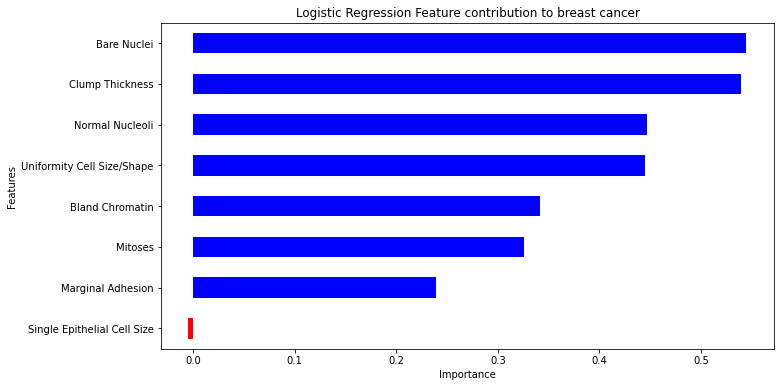

In [343]:
coeff = list(LogReg.coef_[0])# defining coefficient variable 
labels = list(data_upsampled.iloc[:,:-1].columns)# defining label list
features1 = pd.DataFrame() # Creating a new data frame 
features1['Features'] = labels # labels in dataframe 
features1['importance'] = coeff # values in dataframe 
features1.sort_values(by=['importance'], ascending=True, inplace=True) 
features1['positive'] = features1['importance'] > 0 # ranking of feat. 
features1.set_index('Features', inplace=True) 
features1.importance.plot(kind='barh', figsize=(11, 6),color = features1.positive.map({True: 'blue', False: 'red'})) 
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Logistic Regression Feature contribution to breast cancer') 
plt.show()

### SVM 

In [348]:
from sklearn.svm import SVC 



svm_params_grid = { 'kernel':['linear','poly','rbf','sigmoid'],'C':[0.01,0.1,1,10],
              'gamma':['scale','auto'],'random_state':[23]}


svm_gs = GridSearchCV(SVC(),svm_params_grid,cv=cross_val,n_jobs = - 1)
svm_results = svm_gs.fit(x_train,y_train)

svm_results.best_estimator_,svm_results.best_params_

(SVC(C=10, random_state=23),
 {'C': 10, 'gamma': 'scale', 'kernel': 'rbf', 'random_state': 23})

In [344]:
svm = SVC(C=10,kernel='rbf',gamma='scale',random_state=23)

svm.fit(x_train,y_train)

svm_pred = svm.predict(x_test)

svm_f1 = f1_score(y_test,svm_pred)
svm_auroc = roc_auc_score(y_test,svm_pred)

print('F1 score for SVM: {:.4f}'.format(svm_f1),'\n',
     'AUROC score for SVM: {:.4f}'.format(svm_auroc))

F1 score for SVM: 0.9573 
 AUROC score for SVM: 0.9618


Feature importances for SVM can only be determined if we use a linear kernel.  Therefore, we will use the scores of the best parameters for comparison but will use a linear kernel for visualizing feature importance. 

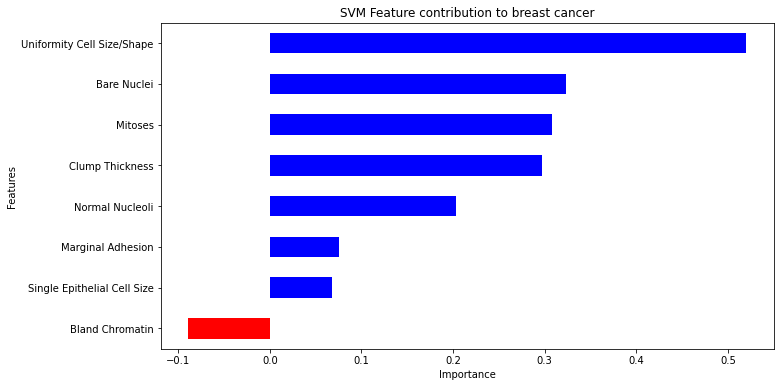

In [350]:
svm_lin = SVC(C=10,kernel='linear',gamma='scale',random_state=23)

svm_lin.fit(x_train,y_train)

coeff = list(svm_lin.coef_[0])# defining coefficient variable 
labels = list(data_upsampled.iloc[:,:-1].columns)# defining label list
features1 = pd.DataFrame() # Creating a new data frame 
features1['Features'] = labels # labels in dataframe 
features1['importance'] = coeff # values in dataframe 
features1.sort_values(by=['importance'], ascending=True, inplace=True) 
features1['positive'] = features1['importance'] > 0 # ranking of feat. 
features1.set_index('Features', inplace=True) 
features1.importance.plot(kind='barh', figsize=(11, 6),color = features1.positive.map({True: 'blue', False: 'red'})) 
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('SVM Feature contribution to breast cancer') 
plt.show()

### Decision Tree 

In [351]:
from sklearn.tree import DecisionTreeClassifier

dt_params =  { 'criterion':['gini','entropy','log_loss'],
              'splitter':['best','random'],'random_state':[23]
             }

dt_gs = GridSearchCV(DecisionTreeClassifier(),dt_params,
                    cv = cross_val, n_jobs =-1)

dt_gs.fit(x_train,y_train)

dt_gs.best_params_

{'criterion': 'gini', 'random_state': 23, 'splitter': 'random'}

In [352]:
dt = DecisionTreeClassifier(criterion = 'gini',splitter='random',random_state=23)

dt.fit(x_train,y_train)
dt_pred = dt.predict(x_test)

dt_f1 = f1_score(y_test,dt_pred)
dt_auroc = roc_auc_score(y_test,dt_pred)

print('F1 score for DecisionTree: {:.4f}'.format(dt_f1),'\n',
     'AUROC score for DecisionTree: {:.4f}'.format(dt_auroc))

F1 score for DecisionTree: 0.9665 
 AUROC score for DecisionTree: 0.9701


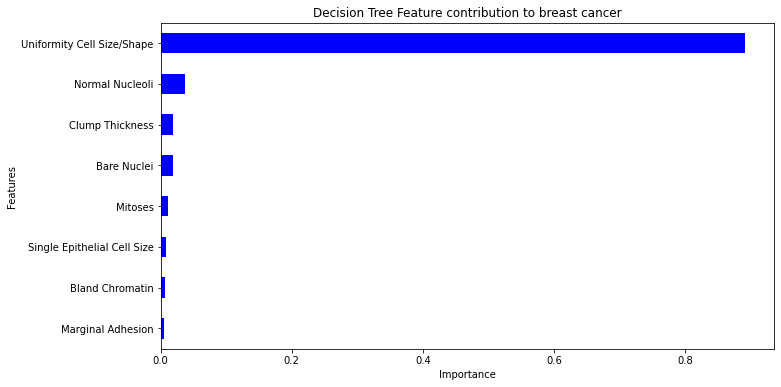

In [353]:
coeff = list(dt.feature_importances_)# defining coefficient variable 
labels = list(data_upsampled.iloc[:,:-1].columns)# defining label list
features1 = pd.DataFrame() # Creating a new data frame 
features1['Features'] = labels # labels in dataframe 
features1['importance'] = coeff # values in dataframe 
features1.sort_values(by=['importance'], ascending=True, inplace=True) 
features1['positive'] = features1['importance'] > 0 # ranking of feat. 
features1.set_index('Features', inplace=True) 
features1.importance.plot(kind='barh', figsize=(11, 6),color = features1.positive.map({True: 'blue', False: 'red'})) 
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Decision Tree Feature contribution to breast cancer') 
plt.show()

### Random Forest 

In [355]:
from sklearn.ensemble import RandomForestClassifier

rf_params = {'n_estimators':[10,50,100,200,500],'criterion':['gini','entropy','log_loss'],
            'class_weight':['balanced','balanced_subsample'],'random_state':[23]}

rf_gs = GridSearchCV(RandomForestClassifier(),rf_params,cv=cross_val,
                    n_jobs=-1)

rf_gs.fit(x_train,y_train)
rf_gs.best_params_

{'class_weight': 'balanced',
 'criterion': 'entropy',
 'n_estimators': 10,
 'random_state': 23}

In [354]:
rf = RandomForestClassifier(n_estimators=10,class_weight='balanced',
                           criterion='entropy',random_state=23)

rf.fit(x_train,y_train)
rf_pred = rf.predict(x_test)

rf_f1 = f1_score(y_test,rf_pred)
rf_auroc = roc_auc_score(y_test,rf_pred)


print('F1 score for Random Forest: {:.4f}'.format(rf_f1),'\n',
     'AUROC score for Random Forest: {:.4f}'.format(rf_auroc))

F1 score for Random Forest: 0.9510 
 AUROC score for Random Forest: 0.9547


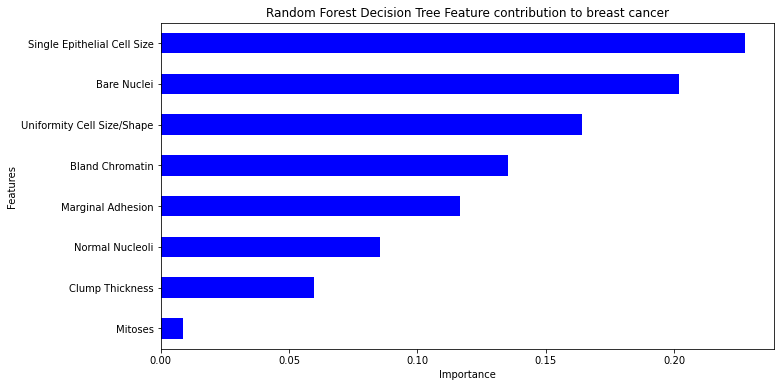

In [356]:
coeff = list(rf.feature_importances_)# defining coefficient variable 
labels = list(data_upsampled.iloc[:,:-1].columns)# defining label list
features1 = pd.DataFrame() # Creating a new data frame 
features1['Features'] = labels # labels in dataframe 
features1['importance'] = coeff # values in dataframe 
features1.sort_values(by=['importance'], ascending=True, inplace=True) 
features1['positive'] = features1['importance'] > 0 # ranking of feat. 
features1.set_index('Features', inplace=True) 
features1.importance.plot(kind='barh', figsize=(11, 6),color = features1.positive.map({True: 'blue', False: 'red'})) 
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Random Forest Decision Tree Feature contribution to breast cancer') 
plt.show()

### AdaBoost 

In [331]:
from sklearn.ensemble import AdaBoostClassifier

ab_params = {'n_estimators':[10,50,100,150,300],'learning_rate':[0.1,1,5,10],
            'random_state':[23]}

ab_gs = GridSearchCV(AdaBoostClassifier(),ab_params,cv=cross_val,
                    n_jobs=-1)

ab_gs.fit(x_train,y_train)
ab_gs.best_params_

{'learning_rate': 0.1, 'n_estimators': 300, 'random_state': 23}

In [357]:
ab = AdaBoostClassifier(n_estimators=300,learning_rate=0.1,random_state=23)

ab.fit(x_train,y_train)
ab_pred = ab.predict(x_test)

ab_f1 = f1_score(y_test,ab_pred)
ab_auroc = roc_auc_score(y_test,ab_pred)


print('F1 score for AdaBoost: {:.4f}'.format(ab_f1),'\n',
     'AUROC score for AdaBoost: {:.4f}'.format(ab_auroc))

F1 score for AdaBoost: 0.9665 
 AUROC score for AdaBoost: 0.9701


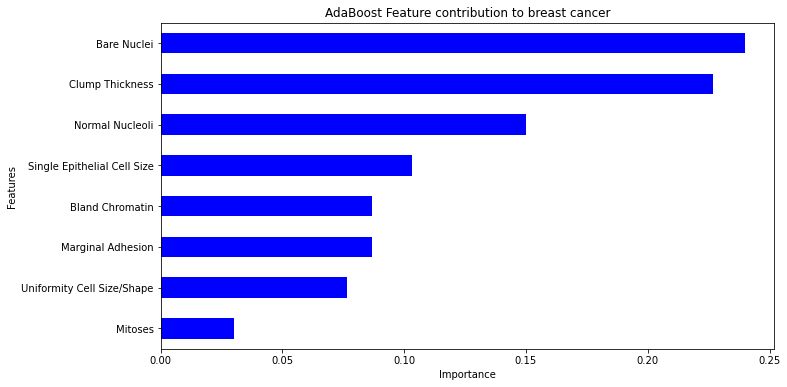

In [358]:
coeff = list(ab.feature_importances_)# defining coefficient variable 
labels = list(data_upsampled.iloc[:,:-1].columns)# defining label list
features1 = pd.DataFrame() # Creating a new data frame 
features1['Features'] = labels # labels in dataframe 
features1['importance'] = coeff # values in dataframe 
features1.sort_values(by=['importance'], ascending=True, inplace=True) 
features1['positive'] = features1['importance'] > 0 # ranking of feat. 
features1.set_index('Features', inplace=True) 
features1.importance.plot(kind='barh', figsize=(11, 6),color = features1.positive.map({True: 'blue', False: 'red'})) 
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('AdaBoost Feature contribution to breast cancer') 
plt.show()

###  Gradient Boost 

In [334]:
from sklearn.ensemble import GradientBoostingClassifier 

gb_params = {'loss':['log_loss','exponential'],'learning_rate' : [0.1,1,10],
            'n_estimators':[10,50,100,200,300],'criterion':['friedman_mse','squared_error'],'random_state':[23]}

gb_gs = GridSearchCV(GradientBoostingClassifier(),gb_params,cv=cross_val,n_jobs=-1)

gb_gs.fit(x_train,y_train)

gb_gs.best_params_

{'criterion': 'friedman_mse',
 'learning_rate': 1,
 'loss': 'exponential',
 'n_estimators': 50,
 'random_state': 23}

In [359]:
gb = GradientBoostingClassifier(criterion='friedman_mse',learning_rate=1,
                               loss='exponential',n_estimators=50,random_state=23)

gb.fit(x_train,y_train)

gb_pred = gb.predict(x_test)

gb_f1 = f1_score(y_test,gb_pred)
gb_auroc = roc_auc_score(y_test,gb_pred)

print('F1 score for Gradient Boosting: {:.4f}'.format(gb_f1),'\n',
     'AUROC score for Gradient Boosting: {:.4f}'.format(gb_auroc))

F1 score for Gradient Boosting: 0.9619 
 AUROC score for Gradient Boosting: 0.9659


### Comparing All Scores 

In [360]:
f1_scores = [knn_f1,lr_f1,svm_f1,dt_f1,rf_f1,ab_f1,gb_f1]
auroc_scores = [knn_auroc,lr_auroc,svm_auroc,dt_auroc,rf_auroc,ab_auroc,gb_auroc]

import pandas as pd 
d = {'F1 Score':f1_scores,'AUROC Score':auroc_scores}
df = pd.DataFrame(d)
df.index = ['kNN','Logistic Regression','SVM','Decision Tree','Random Forest',
           'AdaBoost','Gradient Boosting']
df


,F1 Score,AUROC Score
kNN,0.957346,0.961765
Logistic Regression,0.971154,0.974265
SVM,0.957346,0.961765
Decision Tree,0.966507,0.970098
Random Forest,0.950980,0.954657
AdaBoost,0.966507,0.970098
Gradient Boosting,0.961905,0.965931


From the metric comparison, we can see that logistic regression has the highest score both for F1 and area under the curve.  

-------------

# Feature Importance Evaluation 

Let's see which features were deemed most important in the best scoring algorithm

In [361]:
lr_coeff=LogReg.coef_[0] #feature coefficients from the Logistic Regression run 

labels = list(data_upsampled.iloc[:,:-1].columns)# defining label list
features1 = pd.DataFrame() 
features1['Features'] = labels 
features1['Logistic Regression Importance'] = lr_coeff

features_sorted = features1.sort_values(by = 'Logistic Regression Importance',ascending=False,axis=0)
features_sorted

,Features,Logistic Regression Importance
7,Mitoses,1.062615
0,Clump Thickness,0.969065
2,Marginal Adhesion,0.855322
4,Bare Nuclei,0.803845
6,Normal Nucleoli,0.570217
5,Bland Chromatin,0.196785
3,Single Epithelial Cell Size,0.040936
1,Uniformity Cell Size/Shape,-0.022019


According to our best performing ML algorithm following features are the top 5 features that have the most effect on breast cancer malignancy: 
1. Mitoses 
2. Clump Thickness 
3. Marginal Adhesion 
4. Bare Nuclei 
5. Normal Nucleoli

# Literature Review

In our analysis, top 3 morphological features that have the most impact on breast cancer prognosis were mitoses (mitotic count), clump thickness and marginal adhesion.  

One of the main techniques used to characterize tumors is histological grading.  This technique includes assigning a grade to observed tumor based on three morphological characteristics[1]. Mitotic count is one of these characteristics used as a prognosis predictor factor in many histological tumor grading systems including the Nottingham Grading System[2] . These grading systems associate high mitotic counts with worse disease prognosis  [3]  [4].  This confirms our findings that mitotic count is a significant indicator of breast cancer malignancy.  However, in practice, the concern of reproducibility and lack of standardization around the grading techniques due to its subjective nature has loomed large and mitotic count was deemed a moderate strength prognostic factor[5][6].  

Cell adhesion is known to play a role in malignant transformation and metastasis[7] [8]. There were studies inspecting the prognostic marker strength of certain cellular components that play a role in adhesion processes. Cathepsin D [9], urokinase plasminogen activator system (uPA), epithelial cell adhesion molecule (Ep-CAM)[10]  and plasminogen activator inhibitors (PAI-1/2) [11] are among the markers studied.  However, due to mixed results on the strength of these markers, using cell adhesion factors for directing diagnosis and treatment hasn’t become widespread in the field[5].  Therefore, we can say that our model performed well in selecting marginal adhesion as a significant prognostic factor but the practical evaluation of this factor seems challenging. 

Clump thickness was the second most important feature according to our analysis.  This feature doesn’t have many high experimental literature verifying it’s validity as a prognostic factor but there are studies in which different ML algorithms were designed to predict breast cancer malignancy and evaluated the feature importance of clump thickness. In one study by Chaurasia and Pal [12] , a combination of classifiers identified clump thickness as one of the least important features. In another approach, clump thickness was among the lowest contributing features alongside mitosis and marginal adhesion[13].  Contradicting to these results, another article ranked clump thickness among the top 5 features with the highest weight on determining the malignancy[14]. With these nonuniform results it’s hard to classify clump thickness as an important prognostic factor.  One can comment that our algorithm encounters difficulties with making sense of clump thickness values, similar to the classification methods developed previously.  

Overall, one can see that due to the complex nature of cancer, different features can be assigned different importance values depending on the analysis.  Our best fitting algorithm has accuracy figures comparable to the literature however, it is hard to comment on our model’s success in determining important prognostic features.  This is due to the heterogeneity of assigned feature importances in the literature. We were able to find supporting evidence for mitotic counts and marginal adhesion as strong prognostic factor but there doesn’t seem to be a consensus on the importance of clump thickness seems in the literature. 

If we want to summarize our results, we can say that all of the algorithms we optimized had an F1 and AUROC score higher than 0.95.  This means that all of our algorithms are pretty accurate. There could be various reasons why linear regression model exhibited the highest accuracy.  Our dataset could be exhibiting high data separability.  Also having a balanced set contributes to the high accuracy. More specifically though, our dataset contains morphological features and cancer is a disease in which morphological features of the cells are disrupted more and more as the disease progresses.  One can already deduce a linear relationship between disease progression and deteriorated morphological features.  Our analysis statistically supports the linear correlation. 


### References

[1]	R. A. Saez, W. L. McGuire, and G. M. Clark, ‘Prognostic factors in breast cancer’, Semin Surg Oncol, vol. 5, no. 2, pp. 102–110, 1989, doi: 10.1002/ssu.2980050206.

[2]	‘Breast cancer prognostic classification in the molecular era: the role of histological grade ’.

[3]	C. W. ELSTON and I. O. ELLIS, ‘pathological prognostic factors in breast cancer. I. The value of histological grade in breast cancer: experience from a large study with long‐term follow‐up’, Histopathology, vol. 19, no. 5, pp. 403–410, 1991, doi: 10.1111/j.1365-
2559.1991.tb00229.x.

[4]	E. A. Rakha et al., ‘Prognostic significance of nottingham histologic grade in invasive breast carcinoma’, Journal of Clinical Oncology, vol. 26, no. 19, pp. 3153–3158, 2008, doi: 10.1200/JCO.2007.15.5986.

[5]	D. F. Hayes, C. Isaacs, and V. Stearns, ‘Prognostic Factors in Breast Cancer: Current and New Predictors of Metastasis’, 2001.

[6]	W. L. McGuire and G. M. Clark, ‘Prognostic Factors and Treatment Decisions in Axillary-Node-Negative Breast Cancer’, The New England Journal of Medicine , vol. 326, no. 26, pp. 1756–1761, 1992.

[7]	M. Janiszewska, M. C. Primi, and T. Izard, ‘Cell adhesion in cancer: Beyond the migration of single cells’, Journal of Biological Chemistry, vol. 295, no. 8, pp. 2495–2505, Feb. 2020, doi: 10.1074/jbc.REV119.007759.

[8]	B. Sousa, J. Pereira, and J. Paredes, ‘The crosstalk between cell adhesion and cancer metabolism’, International Journal of Molecular Sciences, vol. 20, no. 8. MDPI AG, Apr. 02, 2019. doi: 10.3390/ijms20081933.

[9]	P. M. Ravdin, C. A. De Moor, S. G. Hilsenbeck, M. K. Samoszuk, P. M. Vendely, and G. M. Clark, ‘Lack of prognostic value of cathepsin D levels for predicting short term outcomes of breast cancer patients’, 1997.

[10]	M. Schmidt et al., ‘Prognostic effect of epithelial cell adhesion molecule overexpression in untreated node-negative breast Cancer’, Clinical Cancer Research, vol. 14, no. 18, pp. 5849–5855, Sep. 2008, doi: 10.1158/1078-0432.CCR-08-0669.

[11]	J. A. Foekens et al., ‘The Urokinase System of Plasminogen Activation and Prognosis in 2780 Breast Cancer Patients 1’, 2000. [Online]. Available: http://aacrjournals.org/cancerres/article-pdf/60/3/636/2482234/ch030000636.pdf

[12]	V. Chaurasia and S. Pal, ‘A Novel Approach for Breast Cancer Detection using Data Mining Techniques’. [Online]. Available: https://ssrn.com/abstract=2994932

[13]	L. Borges and L. Rodrigues, ‘Analysis of the Wisconsin Breast Cancer Dataset and Machine Learning for Breast Cancer Detection Quality’, 2015. [Online]. Available: https://www.researchgate.net/publication/311950799

[14]	K. Atrey, Y. Sharma, N. K. Bodhey, and B. K. Singh, ‘Breast cancer prediction using dominance-based feature filtering approach: A comparative investigation in machine learning archetype’, Brazilian Archives of Biology and Technology, vol. 62, pp. 1–15, 2019, doi: 10.1590/1678-4324-2019180486.